In [1]:
pip install tensorflow_datasets

     |████████████████████████████████| 3.3 MB 6.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import urllib


AUTOTUNE = tf.data.experimental.AUTOTUNE




import tensorflow_datasets as tfds
import PIL.Image
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)
import numpy as np

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
IMAGE_PATH = "../input/plant-pathology-2020-fgvc7/images/"
TEST_PATH = "../input/plant-pathology-2020-fgvc7/test.csv"
TRAIN_PATH = "../input/plant-pathology-2020-fgvc7/train.csv"
SUB_PATH = "../input/plant-pathology-2020-fgvc7/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
plant_data = pd.read_csv(TRAIN_PATH)

In [4]:
def format_path(st):
    return IMAGE_PATH + st+'.jpg'

#taking the file path of train and test images
train_paths = plant_data.image_id.apply(format_path).values
test_paths =test_data.image_id.apply(format_path).values

#Taking  the labels of train images
labels = np.float32(plant_data.loc[:, 'healthy':'scab'].values)

#splitting int train and validation 
train_path,val_path,train_lab,val_label=train_test_split(train_paths,labels, test_size=0.3, random_state=42)

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160
#Resize the images to a fixed input size, and rescale the input channels to a range of [-1,1]
def aug_format_example(image, label=None):
    
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image/255) 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

   
   
    if label is None :
        return image
    else:
        return image, label

def format_example(image, label=None):
    
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image/255) 
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    if label is None :
        return image
    else:
        return image, label

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 500
#Apply this function to each item in the dataset using the map method:
train = tf.data.Dataset.from_tensor_slices((train_path, train_lab)).map(aug_format_example)
val=tf.data.Dataset.from_tensor_slices((val_path, val_label)).map(format_example)
test=tf.data.Dataset.from_tensor_slices((test_paths)).map(format_example)

In [9]:
#Now shuffle and batch the data.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches =val.batch(BATCH_SIZE)
test_batches=test.batch(BATCH_SIZE)

In [10]:
#Inspect a batch of data:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [11]:
IMG_SIZE=160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model =tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [12]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(4,activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [17]:
model = tf.keras.models.Sequential([base_model,
                                 global_average_layer ,
                            prediction_layer,
                                ])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [20]:
initial_epochs = 10
validation_steps=20

In [21]:
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [22]:
def decay(epochs):
    if epochs < 3:
        return 1e-3
    elif epochs >= 3 and epochs < 7:
        return 1e-4
    else:
        return 1e-5

In [23]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [24]:
callbacks = [
    
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [25]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks,
              
                    validation_data=validation_batches)

Train for 40 steps, validate for 18 steps
Epoch 1/10
39/40 [============================>.] - ETA: 1s - loss: 0.4745 - accuracy: 0.7825
Learning rate for epoch 1 is 0.0010000000474974513
40/40 [==============================] - 57s 1s/step - loss: 0.4718 - accuracy: 0.7832 - val_loss: 0.4452 - val_accuracy: 0.7930
Epoch 2/10
39/40 [============================>.] - ETA: 0s - loss: 0.3209 - accuracy: 0.8750
Learning rate for epoch 2 is 0.0010000000474974513
40/40 [==============================] - 49s 1s/step - loss: 0.3225 - accuracy: 0.8740 - val_loss: 0.3984 - val_accuracy: 0.8309
Epoch 3/10
39/40 [============================>.] - ETA: 0s - loss: 0.2711 - accuracy: 0.9034
Learning rate for epoch 3 is 0.0010000000474974513
40/40 [==============================] - 50s 1s/step - loss: 0.2703 - accuracy: 0.9038 - val_loss: 0.3588 - val_accuracy: 0.8496
Epoch 4/10
39/40 [============================>.] - ETA: 0s - loss: 0.2596 - accuracy: 0.9022
Learning rate for epoch 4 is 9.99999974737

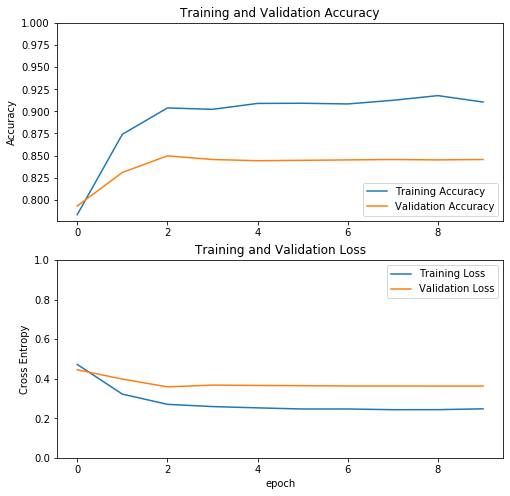

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Standard Convolution


In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [47]:
num_features=40
IMG_SHAPE_ = (IMG_SIZE, IMG_SIZE, 3)
model_con = Sequential()

#module 1
model_con.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(IMG_SHAPE), data_format='channels_last'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model_con.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model_con.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))
model_con.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model_con.add(Flatten())

#dense 1
model_con.add(Dense(2*num_features))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))

#dense 2
model_con.add(Dense(num_features))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))

#dense 3
model_con.add(Dense(num_features))
model_con.add(BatchNormalization())
model_con.add(Activation('relu'))

#output layer
model_con.add(Dense(4, activation='sigmoid'))

model_con.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model_con.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 158, 158, 160)     4480      
_________________________________________________________________
batch_normalization_18 (Batc (None, 158, 158, 160)     640       
_________________________________________________________________
activation_18 (Activation)   (None, 158, 158, 160)     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 158, 158, 160)     230560    
_________________________________________________________________
batch_normalization_19 (Batc (None, 158, 158, 160)     640       
_________________________________________________________________
activation_19 (Activation)   (None, 158, 158, 160)     0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 79, 79, 160)      

In [48]:
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [49]:
history_ = model_con.fit(train_batches,
                    epochs=initial_epochs,
                    callbacks=callbacks,
              
                    validation_data=validation_batches)

Train for 40 steps, validate for 18 steps
Epoch 1/10
39/40 [============================>.] - ETA: 16s - loss: 0.6770 - accuracy: 0.6260
Learning rate for epoch 1 is 9.999999747378752e-06
40/40 [==============================] - 709s 18s/step - loss: 0.6748 - accuracy: 0.6279 - val_loss: 0.6544 - val_accuracy: 0.6426
Epoch 2/10
39/40 [============================>.] - ETA: 15s - loss: 0.5326 - accuracy: 0.7522
Learning rate for epoch 2 is 9.999999747378752e-06
40/40 [==============================] - 710s 18s/step - loss: 0.5334 - accuracy: 0.7516 - val_loss: 0.6946 - val_accuracy: 0.6691
Epoch 3/10
39/40 [============================>.] - ETA: 15s - loss: 0.4231 - accuracy: 0.8233
Learning rate for epoch 3 is 9.999999747378752e-06
40/40 [==============================] - 703s 18s/step - loss: 0.4223 - accuracy: 0.8234 - val_loss: 0.6087 - val_accuracy: 0.7500
Epoch 4/10
39/40 [============================>.] - ETA: 15s - loss: 0.3544 - accuracy: 0.8650
Learning rate for epoch 4 is 9.9

In [51]:
acc = history_.history['accuracy']
val_acc = history_.history['val_accuracy']

loss = history_.history['loss']
val_loss = history_.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

AttributeError: 'History' object has no attribute 'history_'